<a href="https://colab.research.google.com/github/Youlenda/Curriculum-Vitae/blob/main/notebooks/segmentation_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Segmentation Tracking with DINOv3

This notebook demonstrates using DINOv3 for video segmentation tracking
using a non-parametric method similar to
["Space-time correspondence as a contrastive random walk" (Jabri et al. 2020)](https://arxiv.org/abs/2006.14613).

Given:
- RGB video frames
- Instance segmentation masks for the first frame

We will extract patch features from each frame and use patch similarity
to propagate the ground-truth labels to all frames.

## Setup

Let's start by loading some pre-requisites, setting up the environment and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [22]:
!pip install lovely_tensors
!pip install mediapy

In [23]:
import datetime
import functools
import io
import logging
import math
import os
from pathlib import Path
import tarfile
import time
import urllib

import lovely_tensors
import matplotlib.pyplot as plt
import mediapy as mp
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.transforms as TVT
import torchvision.transforms.functional as TVTF
from torch import Tensor, nn
from tqdm import tqdm

DISPLAY_HEIGHT = 200
lovely_tensors.monkey_patch()
torch.set_grad_enabled(False)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

DINOv3 location set to facebookresearch/dinov3


## Model

We load the DINOv3 ViT-L model and get some attributes. Feel free to try other DINOv3 models as well!

In [24]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# we take DINOv3 ViT-L
MODEL_NAME = MODEL_DINOV3_VITL

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="github",
    weights="/content/drive/MyDrive/dino/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth"
)
# model.to("cuda")
model.eval()

patch_size = model.patch_size
embed_dim = model.embed_dim
print(f"Patch size: {patch_size}")
print(f"Embedding dimension: {embed_dim}")
print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() / 2**30:.1f} GB")

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


Patch size: 16
Embedding dimension: 1024
Peak GPU memory: 0.0 GB


We want to process one image at the time and get L2-normalized features.
Here is a wrapper to do just that.

In [25]:
@torch.compile(disable=True)
def forward(
    model: nn.Module,
    img: Tensor,  # [3, H, W] already normalized for the model
) -> Tensor:
    feats = model.get_intermediate_layers(img.unsqueeze(0), n=1, reshape=True)[0]  # [1, D, h, w]
    feats = feats.movedim(-3, -1)  # [1, h, w, D]
    feats = F.normalize(feats, dim=-1, p=2)
    return feats.squeeze(0)  # [h, w, D]

## Data

Here we load the video frames and the instance segmentation masks for the first frame.


This notebook assumes that the video has already been processed to extract individual frames as `.jpg` images in the current directory.
```txt
000001.jpg
000002.jpg
...
```

To run this notebook on your own `.mp4` video, use `ffmpeg` to extract frames at 24 FPS:
```bash
INPUT_VIDEO="video.mp4"
OUTPUT_DIR="."
ffmpeg -hide_banner -i "${INPUT_VIDEO}" -qscale:v 2 -vf fps=24 -y "${OUTPUT_DIR}/%06d.jpg"
```

In [91]:
import tarfile, io, re
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import numpy as np

VIDEO_FRAMES_PATH = "/content/drive/MyDrive/dino/5.tar.gz"
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
number_re = re.compile(r"\d+")

def load_video_frames(tar_path: str):
    images, indices = [], []

    with tarfile.open(tar_path, "r:gz") as tar:
        for member in tar.getmembers():
            # 1) keep only regular files (not dirs, symlinks, etc.)
            if not member.isfile():
                continue

            # 2) ignore dot-underscore & other hidden files
            if member.name.startswith("._") or "/._" in member.name:
                continue

            # 3) ignore entries with no data
            if member.size == 0:
                continue

            # 4) keep only recognised image extensions
            ext = Path(member.name).suffix.lower()
            if ext not in IMAGE_EXTS:
                continue

            # numeric part of filename (for ordering); fallback = current length
            m = number_re.search(Path(member.name).stem)
            idx = int(m.group()) if m else len(indices)

            with tar.extractfile(member) as f:
                try:
                    img = Image.open(io.BytesIO(f.read()))
                    img.load()                    # fully read to detect corrupt
                except (UnidentifiedImageError, OSError) as e:
                    print(f"⚠️  Skipping {member.name}: {e}")
                    continue                      # skip bad entry

            images.append(img.convert("RGB"))
            indices.append(idx)

    # sort frames by their numeric index
    order = np.argsort(indices)
    return [images[i] for i in order]

frames = load_video_frames(VIDEO_FRAMES_PATH)
num_frames = len(frames)
print("Loaded", len(frames), "good frames")
print("First frame size:", frames[0].size if frames else "n/a")


Loaded 8 good frames
First frame size: (2880, 2880)


Let's show four sample frames from the video:

Frame 0,Frame 2,Frame 4,Frame 7

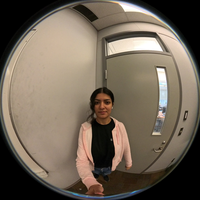
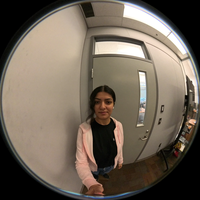
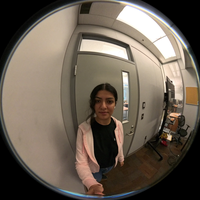
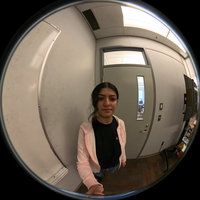

In [93]:
num_selected_frames = 4
selected_frames = np.linspace(0, num_frames - 1, num_selected_frames, dtype=int)

mp.show_images(
    [frames[int(i)] for i in selected_frames],
    titles=[f"Frame {i}" for i in selected_frames],
    height=DISPLAY_HEIGHT,
)

This notebook assumes that instance segmentation masks for the first frame are stored in a `.png` file:
- A value of `0` indicates the background.
- Object instances are represented by progressive contiguous `uint8` indices starting from `1`.

We created the example mask using [SAM 2](), but Paint would work just as well.

A function to visualize the masks as RGB is also provided.

Mask size: [2880, 2880]
Number of masks: 2


Frame,Mask

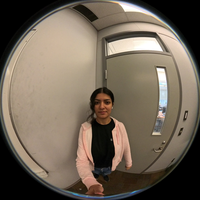
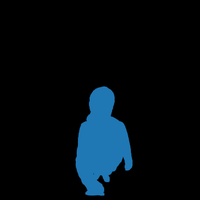

In [94]:
def mask_to_rgb(mask: np.ndarray | Tensor, num_masks: int) -> np.ndarray:
    if isinstance(mask, Tensor):
        mask = mask.cpu().numpy()

    # Exclude background
    background = mask == 0
    mask = mask - 1
    num_masks = num_masks - 1

    # Choose palette
    if num_masks <= 10:
        mask_rgb = plt.get_cmap("tab10")(mask)[..., :3]
    elif num_masks <= 20:
        mask_rgb = plt.get_cmap("tab20")(mask)[..., :3]
    else:
        mask_rgb = plt.get_cmap("gist_rainbow")(mask / (num_masks - 1))[..., :3]

    mask_rgb = (mask_rgb * 255).astype(np.uint8)
    mask_rgb[background, :] = 0
    return mask_rgb


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f)


first_mask_np = np.array(
    Image.open(
        # "https://dl.fbaipublicfiles.com/dinov3/notebooks/segmentation_tracking/first_video_frame_mask.png"
        "/content/drive/MyDrive/dino/back_frame_0005.jpg"
    )
)/255

mask_height, mask_width = first_mask_np.shape  # Abbreviated at [H', W']
print(f"Mask size: {[mask_height, mask_width]}")
# breakpoint()
num_masks = int(first_mask_np.max() + 1)  # Abbreviated as M
print(f"Number of masks: {num_masks}")

mp.show_images(
    [frames[0], mask_to_rgb(first_mask_np, num_masks)],
    titles=["Frame", "Mask"],
    height=DISPLAY_HEIGHT,
)

Time for some math! Input frames need to be resized to match the desired forward resolution and the model patch size.

The desired forward resolution refers to the _short side_ of the input.
If the desired resolution is not a multiple of the patch size, we simply round it up.
Then, we determine the _long side_ by maintaining the original aspect ratio as much as possible, but rounding up to the patch size as well.

With the occasion, we'll also setup the torchvision transforms and test them out on the first frame.

In [95]:
class ResizeToMultiple(nn.Module):
    def __init__(self, short_side: int, multiple: int):
        super().__init__()
        self.short_side = short_side
        self.multiple = multiple

    def _round_up(self, side: float) -> int:
        return math.ceil(side / self.multiple) * self.multiple

    def forward(self, img):
        old_width, old_height = TVTF.get_image_size(img)
        if old_width > old_height:
            new_height = self._round_up(self.short_side)
            new_width = self._round_up(old_width * new_height / old_height)
        else:
            new_width = self._round_up(self.short_side)
            new_height = self._round_up(old_height * new_width / old_width)
        return TVTF.resize(img, [new_height, new_width], interpolation=TVT.InterpolationMode.BICUBIC)


SHORT_SIDE = 960

transform = TVT.Compose(
    [
        ResizeToMultiple(short_side=SHORT_SIDE, multiple=patch_size),
        TVT.ToTensor(),
        TVT.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
first_frame = transform(frames[0])
print(f"First frame: {first_frame}")

_, frame_height, frame_width = first_frame.shape  # Abbreviated as [H, W]
feats_height, feats_width = frame_height // patch_size, frame_width // patch_size  # Abbreviated as [h, w]

First frame: tensor[3, 960, 960] n=2764800 (11Mb) x∈[-2.118, 2.640] μ=-0.239 σ=1.164


Label propagation happens at the output resolution of the model,
so we downsample the ground-truth masks of the first frame and turn them into a one-hot probability map.

In [96]:
first_mask = torch.from_numpy(first_mask_np)#.to("cuda", dtype=torch.long)  # [H', W']
first_mask = F.interpolate(
    first_mask[None, None, :, :].float(),  # [1, 1, H', W']
    (feats_height, feats_width),
    mode="nearest-exact",
)[0, 0].long()  # [h, w]
print(f"First mask:  {first_mask}")

first_probs = F.one_hot(first_mask, num_masks).float()  # [h, w, M]
print(f"First probs: {first_probs}")

First mask:  tensor[60, 60] i64 n=3600 (28Kb) x∈[0, 1] μ=0.095 σ=0.293
First probs: tensor[60, 60, 2] n=7200 (28Kb) x∈[0., 1.000] μ=0.500 σ=0.500


## How it works

And now the fun part!

Label propagation takes as input:
- The features of the current frame, with shape `[h, w, D]`
- The features of the `t` context frames, with shape `[t, h, w, D]`
- The mask probabilities of `t` context frames, with shape `[t, h, w, M]`

For each patch of the current frame:
- We compute the cosine similarity with all context patches.
- We restrict the focus to a local neighborhood and select the top-k most similar context patches.
- We compute a weighted average of the mask probabilities of the selected patches to obtain a prediction for the mask probabilies of the current patch.

In [97]:
@torch.compile(disable=True)
def propagate(
    current_features: Tensor,  # [h", w", D], where h=h", w=w", and " stands for current
    context_features: Tensor,  # [t, h, w, D]
    context_probs: Tensor,  # [t, h, w, M]
    neighborhood_mask: Tensor,  # [h", w", h, w]
    topk: int,
    temperature: float,
) -> Tensor:
    t, h, w, M = context_probs.shape

    # Compute similarity current -> context
    dot = torch.einsum(
        "ijd, tuvd -> ijtuv",
        current_features,  # [h", w", D]
        context_features,  # [t, h, w, D]
    )  # [h", w", t, h, w]

    # Restrict focus to local neighborhood
    dot = torch.where(
        neighborhood_mask[:, :, None, :, :],  # [h", w", 1, h, w]
        dot,  # [h", w", t, h, w]
        -torch.inf,
    )

    # Select top-k patches inside the neighborhood
    dot = dot.flatten(2, -1).flatten(0, 1)  # [h"w", thw]
    k_th_largest = torch.topk(dot, dim=1, k=topk).values  # [h"w", k]
    dot = torch.where(
        dot >= k_th_largest[:, -1:],  # [h"w", thw]
        dot,  # [h"w", thw]
        -torch.inf,
    )

    # Propagate probabilities from context to current frame
    weights = F.softmax(dot / temperature, dim=1)  # [h"w", thw]
    current_probs = torch.mm(
        weights,  # [h"w", thw]
        context_probs.flatten(0, 2),  # [thw, M]
    )  # [h"w", M]

    # Propagated probs should already sum to 1, but just in case
    current_probs = current_probs / current_probs.sum(dim=1, keepdim=True)  # [h"w", M]

    return current_probs.unflatten(0, (h, w))  # [h", w", M]


@functools.lru_cache()
def make_neighborhood_mask(h: int, w: int, size: float, shape: str) -> Tensor:
    ij = torch.stack(
        torch.meshgrid(
            torch.arange(h, dtype=torch.float32, device="cuda"),
            torch.arange(w, dtype=torch.float32, device="cuda"),
            indexing="ij",
        ),
        dim=-1,
    )  # [h, w, 2]
    if shape == "circle":
        ord = 2
    elif shape == "square":
        ord = torch.inf
    else:
        raise ValueError(f"Invalid {shape=}")
    norm = torch.linalg.vector_norm(
        ij[:, :, None, None, :] - ij[None, None, :, :, :],  # [h", w", h, w, 2]
        ord=ord,
        dim=-1,
    )  # [h", w", h, w]
    mask = norm <= size  # [h", w", h, w] bool, True inside, False outside
    return mask

In [98]:
import torch
import math

def make_neighborhood_mask(h, w, *, size=12, shape="circle", device=None):
    """
    Return a [h, w, h, w] boolean tensor where mask[i,j] is True for pixels
    inside the `size`-radius neighbourhood of (i,j).
    """
    # Pick a device if none given
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    yi, xi = torch.meshgrid(
        torch.arange(h, dtype=torch.float32, device=device),
        torch.arange(w, dtype=torch.float32, device=device),
        indexing="ij",
    )                           # yi, xi shape = [h, w]

    # (h, w, 1, 1) – broadcast later
    yi2 = yi[:, :, None, None]
    xi2 = xi[:, :, None, None]

    # (1, 1, h, w)
    yj2 = yi[None, None, :, :]
    xj2 = xi[None, None, :, :]

    if shape == "circle":
        dist2 = (yi2 - yj2) ** 2 + (xi2 - xj2) ** 2
        mask = dist2 <= size ** 2
    else:                       # "square"
        mask = (yi2 - yj2).abs() <= size / 2
        mask &= (xi2 - xj2).abs() <= size / 2

    return mask                 # bool tensor [h, w, h, w]


How does the neighborhood mask look like?

"(3, 14)","(20, 25)"

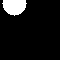
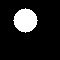

In [99]:
neighborhood_mask = make_neighborhood_mask(
    feats_height, feats_width, size=12, shape="circle"  # device picked automatically
)

mp.show_images(
    {f"{(i, j)}": neighborhood_mask[i, j].cpu().numpy()
     for i, j in [(3, 14), (20, 25)]},
    height=DISPLAY_HEIGHT,
)


To understand how it works, let's do it for one frame only.
The "context" contains only the first frame and the "current frame" is the second one.

In [ ]:
torch._dynamo.maybe_mark_dynamic(first_frame, (1, 2))
first_feats = forward(model, first_frame)  # [h, w, D]
print(f"First feats:   {first_feats.shape}")

frame_idx = 1
current_frame_pil = frames[frame_idx]
current_frame = transform(current_frame_pil)#.to("cuda")  # [3, H, W]
torch._dynamo.maybe_mark_dynamic(current_frame, (1, 2))
current_feats = forward(model, current_frame)  # [h", w", D]
print(f"Current feats: {current_feats.shape}")

current_probs = propagate(
    current_feats,  # [h", w", D]
    context_features=first_feats.unsqueeze(0),  # [1, h, w, D]
    context_probs=first_probs.unsqueeze(0),  # [1, h, w, M]
    neighborhood_mask=neighborhood_mask,  # [h", w", h, w]
    topk=5,
    temperature=0.2,
)  # [h", w", M]
print(f"Current probs:  {current_probs}")

Then, we upsample the predicted probabilities and postprocess them.

Finally, we visualize:
- The first frame with its ground truth next to the second frame with the predicted masks.
- The per-mask probabilties predicted for the second frame.

First frame,Second frame
,

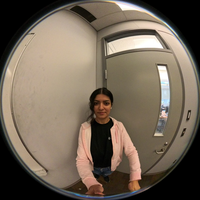
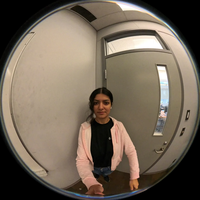
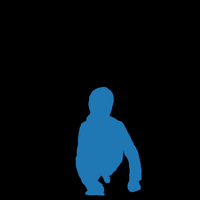
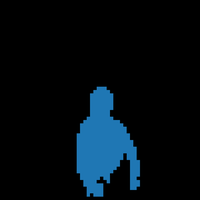

Mask 0,Mask 1

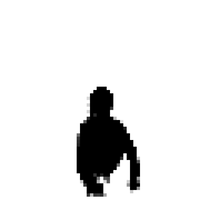
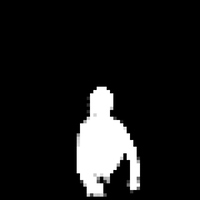

In [69]:
def postprocess_probs(
    probs: Tensor,  # [B, M, H', W']
) -> Tensor:
    vmin = probs.flatten(2, 3).min(dim=2).values  # [B, M]
    vmax = probs.flatten(2, 3).max(dim=2).values  # [B, M]
    probs = (probs - vmin[:, :, None, None]) / (vmax[:, :, None, None] - vmin[:, :, None, None])
    probs = torch.nan_to_num(probs, nan=0)
    return probs  # [B, M, H', W']


p = current_probs.movedim(-1, -3).unsqueeze(0)  # [1, M, h", w"]
p = F.interpolate(p, size=(mask_height, mask_width), mode="nearest")  # [1, M, H', W']
p = postprocess_probs(p).squeeze(0)  # [M, H', W']
current_pred_np = p.argmax(0).cpu().numpy()  # [H', W']
current_probs_np = p.cpu().numpy()  # [M, H', W']
del p

mp.show_images(
    [
        frames[0],
        current_frame_pil,
        mask_to_rgb(first_mask_np, num_masks),
        mask_to_rgb(current_pred_np, num_masks),
    ],
    titles=["First frame", "Second frame", "", ""],
    columns=2,
    height=DISPLAY_HEIGHT,
)

mp.show_images(current_probs_np, titles=[f"Mask {i}" for i in range(num_masks)], height=DISPLAY_HEIGHT)

## Process video

All clear? Time to do it for real!

This time we will process all frames, using a queue of context frames and a queue context mask probabilities.
The queues will contain a limited number of the most recent frames, determined by `max_context_length`.
The first frame is always included in the context and doesn't need to go in the queue.

Let's define all hyperparameters in one place.

In [70]:
MAX_CONTEXT_LENGTH = 7
NEIGHBORHOOD_SIZE = 12
NEIGHBORHOOD_SHAPE = "circle"
TOPK = 5
TEMPERATURE = 0.2

Let's go!

The predicted mask probabilities and the masks, at the original mask resolution, will be stored in `mask_predictions` and `mask_probabilities`.

In [89]:
mask_predictions = torch.zeros([num_frames, mask_height, mask_width], dtype=torch.uint8)  # [T, H', W']
mask_predictions[0, :, :] = torch.from_numpy(first_mask_np)

mask_probabilities = torch.zeros([num_frames, num_masks, mask_height, mask_width])  # [T, M, H', W']
mask_probabilities[0, :, :, :] = F.one_hot(torch.from_numpy(first_mask_np).long(), num_masks).movedim(-1, -3)

features_queue: list[Tensor] = []
probs_queue: list[Tensor] = []

neighborhood_mask = make_neighborhood_mask(
    feats_height,
    feats_width,
    size=NEIGHBORHOOD_SIZE,
    shape=NEIGHBORHOOD_SHAPE,
)  # [h", w", h, w]

start = time.perf_counter()
for frame_idx in tqdm(range(1, num_frames), desc="Processing"):
    # Extract features for the current frame
    current_frame_pil = frames[frame_idx]
    current_frame = transform(current_frame_pil)#.to("cuda")  # [3, H, W]
    torch._dynamo.maybe_mark_dynamic(current_frame, (1, 2))
    current_feats = forward(model, current_frame)  # [h", w", D]

    # Prepare the context, marking the time and mask dimensions as dynamic for torch compile
    context_feats = torch.stack([first_feats, *features_queue], dim=0)  # [1+len(queue), h, w, D]
    context_probs = torch.stack([first_probs, *probs_queue], dim=0)  # [1+len(queue), h, w, M]
    torch._dynamo.maybe_mark_dynamic(context_feats, 0)
    torch._dynamo.maybe_mark_dynamic(context_probs, (0, 3))

    # Propagate segmentation probs from context frames
    current_probs = propagate(
        current_feats,
        context_feats,
        context_probs,
        neighborhood_mask,
        TOPK,
        TEMPERATURE,
    )  # [h", w", M]

    # Update queues with current features and probs
    features_queue.append(current_feats)
    probs_queue.append(current_probs)
    if len(features_queue) > MAX_CONTEXT_LENGTH:
        features_queue.pop(0)
    if len(probs_queue) > MAX_CONTEXT_LENGTH:
        probs_queue.pop(0)

    # Upsample and postprocess segmentation probs, argmax to obtain a prediction
    current_probs = F.interpolate(
        current_probs.movedim(-1, -3)[None, :, :, :],
        size=(mask_height, mask_width),
        mode="nearest",
    )  # [1, M, H', W']
    current_probs = postprocess_probs(current_probs)  # [1, M, H', W']
    current_probs = current_probs.squeeze(0)
    mask_probabilities[frame_idx, :, :, :] = current_probs
    pred = torch.argmax(current_probs, dim=0).to(dtype=torch.uint8)  # [H', W']
    mask_predictions[frame_idx, :, :] = pred  # [H', W']

# torch.cuda.synchronize()
# end = time.perf_counter()
# print(f"Processing time:    {datetime.timedelta(seconds=round(end - start))}")
# print(f"Mask probabilities: {mask_probabilities}")
# print(f"Mask predictions:   {mask_predictions}")

Processing:  50%|█████     | 2/4 [02:31<02:31, 75.73s/it]


IndexError: list index out of range

In [78]:
frames

[<PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>,
 <PIL.Image.Image image mode=RGB size=2880x2880>]

Let's visualize a few frames and a video of the result.

In [83]:
import mediapy as mp

mp.show_images(
    [frames[i].convert("RGB") for i in selected_frames]
    + [mask_to_rgb(mask_predictions[i], num_masks) for i in selected_frames],
    titles=[f"Frame {i}" for i in selected_frames] + [""] * len(selected_frames),
    columns=len(selected_frames),
    height=DISPLAY_HEIGHT,
)

mp.show_videos(
    {
        "Input": [np.array(frame) for frame in frames],
        "Pred": mask_to_rgb(mask_predictions, num_masks),
    },
    height=DISPLAY_HEIGHT,
    fps=24,
)
mp.show_videos(
    {f"Prob {i}": mask_probabilities[:, i].numpy() for i in range(num_masks)},
    height=DISPLAY_HEIGHT,
    fps=24,
)

IndexError: list index out of range

In [85]:
mp.show_videos(
    {
        "Input": [np.array(frame) for frame in frames],
        "Pred": mask_to_rgb(mask_predictions, num_masks),
    },
    height=DISPLAY_HEIGHT,
    fps=24,
)

mp.show_videos(
    {f"Prob {i}": mask_probabilities[:, i].numpy() for i in range(num_masks)},
    height=DISPLAY_HEIGHT,
    fps=24,
)

# Conclusion

This notebook showed how to use DINOv3 for video segmentation tracking.
It should be fairly straightforward to run it to your own video and masks.
The notebook hyperparameters can also be adjusted to see the effect on the results.

Let's discuss GPU memory usage:
- The ViT-L model takes approximately 1.1 GB to load.
- The similarity matrix `dot` inside `propagate()` can get pretty big,
  especially at higher resolution and longer context length.

To reduce memory usage and increase speed, the notebook is already set up to work with `torch.compile()`.
In particular, note the use of `torch._dynamo.maybe_mark_dynamic()` to mark a few dimensions as dynamic
to avoid too many recompilations. To enable compilation, just set `disable` to `False` in the
`@torch.compile()` decorators for the `propagate()` and `forward()` functions.

If you are low on memory, it also possible to use a smaller model and
reduce the forward resolution, but tracking results will look worse.

In [86]:
print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() / 2**30:.1f} GB")

Peak GPU memory: 0.0 GB
